# Fully Connected Network as Implicit Neural Representation

An Implicit Neural Representation is an NN that overfits on a specific fully-known function (or object).

In this coding assignment you'll overfit on a single 2D grayscale image to create an Implicit Neural Representation (INR) mapping 2D coordinate inputs to lightness values.

The INR generated can then be used for downstream tasks. In our case, we will be looking at image super resolution.

**Note:** Ensure you run this notebook on a CUDA GPU to optimize training speed. You can use a GPU instance on Google Colab.

In [ ]:
#@title Install Packages

!python -m pip install einops

%load_ext autoreload
%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 184.9 kB/s eta 0:00:00


In [ ]:
#@title Imports
import einops
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader

import urllib.request
from PIL import Image
from tqdm.autonotebook import tqdm

<ipython-input-2-f95928133e00>:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
########################################
# CHANGE IF YOU REALLY CANNOT USE A GPU.
# KEEP IN MIND THAT THIS WILL SLOW DOWN
# TRAINING BY A LOT.
########################################
allow_cpu = False
if not allow_cpu:
  assert torch.cuda.is_available()

if torch.cuda.is_available():
  print("USING GPU 😊")
  device = torch.device("cuda:0")
else:
  print("WARNING: NOT USING GPU 😡")
  device = torch.device("cpu")

# Image helpers
We now define some helper functions to load and visualize the image

In [ ]:
# Load the image
url = "https://drive.google.com/uc?id=1pWSutVFtWLo8XJqpKL6AgqUC5eeIG9IG"
raw_img = urllib.request.urlopen(url)
raw_img = Image.open(raw_img).convert('L')

def get_img(size):
  im = raw_img.resize((size,size))
  return torch.from_numpy(np.array(im)).to(torch.float)/255

img = get_img(64)

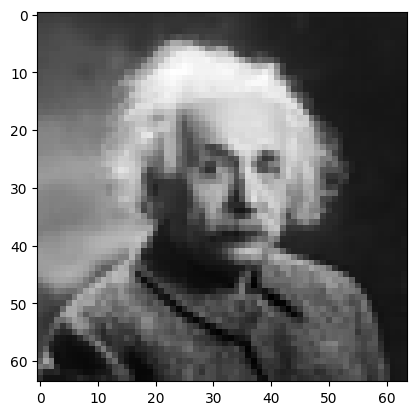

In [ ]:
# Visualize the image
def visualize_data(im):
  plt.imshow(im, cmap='gray')
  plt.show()
visualize_data(img)

# Implement the model

You will explore two different models here. Both will use the same fully connected layer design for comparisons, but they will differ in their input encodings.

The first model will have no input encodings, **implement the model with no input encodings below**.

In [ ]:
# define the model
class INR_FC(torch.nn.Module):
  def __init__(self, hidden_dim=128, encoding_class=None):
    super(INR_FC, self).__init__()
    if encoding_class is None:
      ############################################################################
      # TODO: implement
      self.encoding = nn.Identity()
      self.encoding.out_dim = 2
      ############################################################################
    else:
      self.encoding = encoding_class(2)
    
    self.fc = nn.Sequential(
      nn.Linear(self.encoding.out_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, 1),
    )

  def forward(self, x):
    ############################################################################
    # TODO: implement
    return self.fc(self.encoding(x))
    ############################################################################

In [ ]:
#@title Ensure your code passes the following tests:
torch.manual_seed(100)
model_test = INR_FC()

assert torch.allclose(
    model_test(torch.tensor([0,0],dtype=torch.float)),
    torch.tensor([-0.0651],dtype=torch.float),
    rtol=1e-3
)

assert torch.allclose(
    model_test(torch.tensor([1,0],dtype=torch.float)),
    torch.tensor([-0.0526],dtype=torch.float),
    rtol=1e-3
)

assert torch.allclose(
    model_test(torch.tensor([1/4,1/5],dtype=torch.float)),
    torch.tensor([-0.0632],dtype=torch.float),
    rtol=1e-3
)

assert torch.allclose(
    model_test(torch.tensor([1/3,2/3],dtype=torch.float)),
    torch.tensor([-0.0620],dtype=torch.float),
    rtol=1e-3
)

class IdentityEncoding(nn.Module):
  def __init__(self, in_dim):
    super().__init__()

    self.layer = nn.Identity()
    self.out_dim = in_dim

  def forward(self, x):
    return self.layer(x)

torch.manual_seed(100)
model_test = INR_FC(encoding_class=IdentityEncoding)

assert torch.allclose(
    model_test(torch.tensor([0,0],dtype=torch.float)),
    torch.tensor([-0.0651],dtype=torch.float),
    rtol=1e-3
)

assert torch.allclose(
    model_test(torch.tensor([1,0],dtype=torch.float)),
    torch.tensor([-0.0526],dtype=torch.float),
    rtol=1e-3
)

assert torch.allclose(
    model_test(torch.tensor([1/4,1/5],dtype=torch.float)),
    torch.tensor([-0.0632],dtype=torch.float),
    rtol=1e-3
)

assert torch.allclose(
    model_test(torch.tensor([1/3,2/3],dtype=torch.float)),
    torch.tensor([-0.0620],dtype=torch.float),
    rtol=1e-3
)

In [ ]:
#@title Generate the dataset
def get_dataset(size=None):
  size = img.shape[0] if size is None else size
  x = (torch.arange(size)/size - .5) * 2 # set domain to be [-1, 1] for model interoperability and better performance
  xx, yy = torch.meshgrid(x, x)
  coords = torch.stack([xx.to(device).flatten(), yy.to(device).flatten()], axis=1)
  return TensorDataset(coords.to(torch.float), get_img(size).to(device).flatten())

# Question
**Why do we normalize the input coordinates to be in [-1, 1]?**

# Answer
Normalizing the input coordinates to [-1, 1] is done for 2 reasons:
1. Model interopability: we can reuse a dataset across different Implicit Neural Networks as they all have the same type of input and output.
2. Better learning: normalizing data near 0 allows for better learning due to being near the ReLU elbows at initialization and having well sized gradients.

# Train and test loops
The training loop is a pretty standard one epoch loop. However, in the test loop we wish to visualize the predicted image to see our progress.

**Implement the predicted image reconstruction**.

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
  model.train()
  
  for x, y in dataloader:
    # Compute prediction and loss
    pred = model(x).squeeze()
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def test_loop(dataloader, model, loss_fn, testing=False):
  model.eval()
  size = int(np.sqrt(len(dataloader.dataset)))
  test_loss = 0

  img_pred = torch.empty((size,size),device=device)
  with torch.no_grad():
    for x, y in dataloader:
      pred = model(x).squeeze()
      test_loss += loss_fn(pred, y).item()

      ############################################################################
      # TODO: implement
      coords = ((x/2 + .5)*size).to(torch.int)
      img_pred[coords[:, 0], coords[:, 1]] = pred
      ############################################################################
  
  if testing:
    return img_pred
  
  print(f"Total loss: {test_loss:>8f} \n")
  visualize_data(img_pred.cpu())

In [ ]:
#@title Ensure your code passes the following tests:
torch.manual_seed(100)
model_test = INR_FC()
model_test.to(device)

dataloader_test = DataLoader(get_dataset(2), batch_size=64, shuffle=True)
assert torch.allclose(
    test_loop(dataloader_test,model_test,nn.MSELoss(),testing=True),
    torch.tensor(
        [[-0.0630, -0.0546],
        [-0.0638, -0.0651]],dtype=torch.float,device=device),
    rtol=1e-3
)

dataloader_test = DataLoader(get_dataset(4), batch_size=64, shuffle=True)
assert torch.allclose(
    test_loop(dataloader_test,model_test,nn.MSELoss(),testing=True),
    torch.tensor(
        [[-0.0630, -0.0564, -0.0546, -0.0584],
        [-0.0657, -0.0623, -0.0608, -0.0632],
        [-0.0638, -0.0656, -0.0651, -0.0638],
        [-0.0568, -0.0594, -0.0596, -0.0609]],dtype=torch.float,device=device),
    rtol=1e-3
)

In [ ]:
def train(model, learning_rate = 1e-3, batch_size = 64, epochs = 1000, loss_fn = nn.MSELoss()):
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  dataloader = DataLoader(get_dataset(), batch_size=batch_size, shuffle=True)

  epoch_progress_bar = tqdm(total=epochs)
  epoch_progress_bar.set_description(f"Epoch {0}")

  for t in range(epochs):
    train_loop(dataloader, model, loss_fn, optimizer)

    epoch_progress_bar.update(1)
    epoch_progress_bar.set_description(f"Epoch {t+1}")

    if t % (epochs//10) == 0:
      print(f"Training completed: {t*100//epochs}%")
      test_loop(dataloader, model, loss_fn)

# Train the no-encoding model
The below code now trains the model you have created. At every 10% increment of progress the total reconstruction loss and reconstructed image is outputted.

  0%|          | 0/1000 [00:00<?, ?it/s]

Training completed: 0%
Total loss: 1.751295 



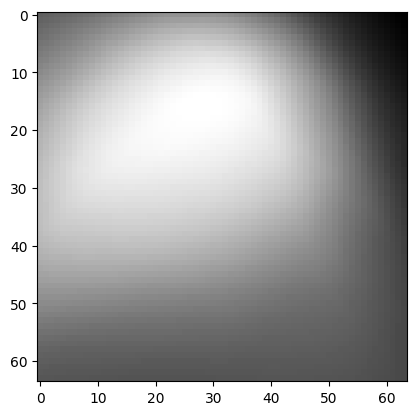

Training completed: 10%
Total loss: 0.226194 



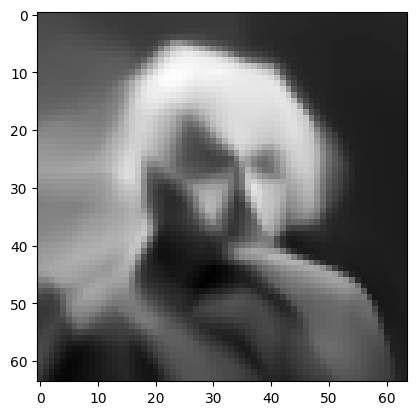

Training completed: 20%
Total loss: 0.155514 



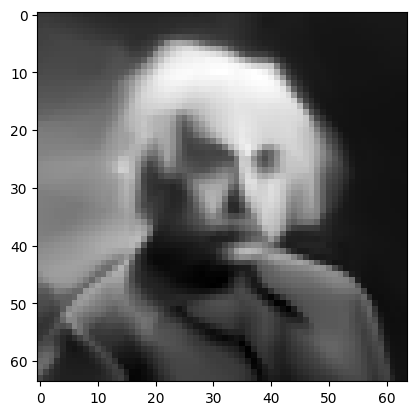

Training completed: 30%
Total loss: 0.070033 



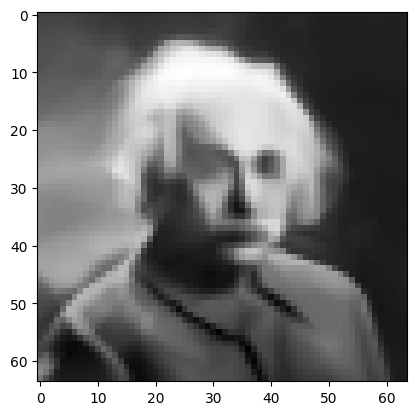

Training completed: 40%
Total loss: 0.067110 



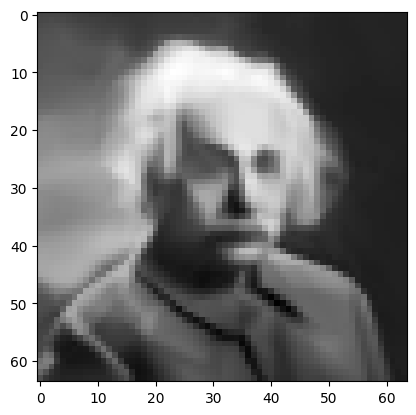

Training completed: 50%
Total loss: 0.053158 



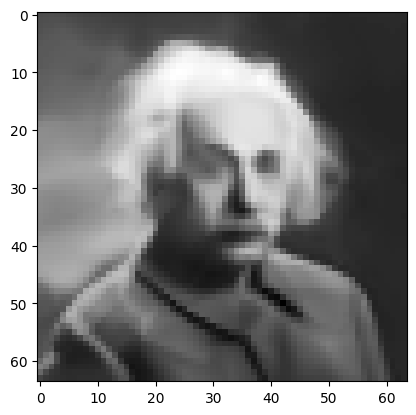

Training completed: 60%
Total loss: 0.040169 



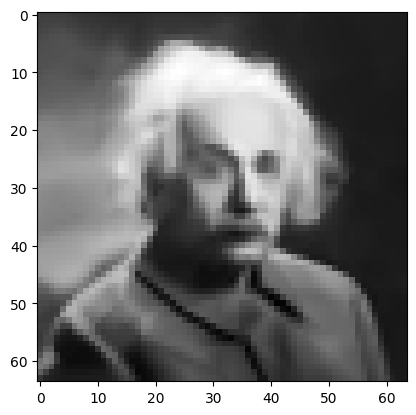

Training completed: 70%
Total loss: 0.035246 



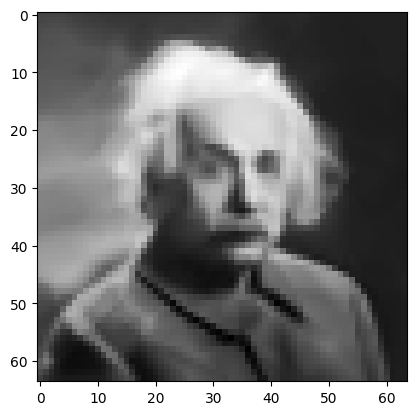

Training completed: 80%
Total loss: 0.044148 



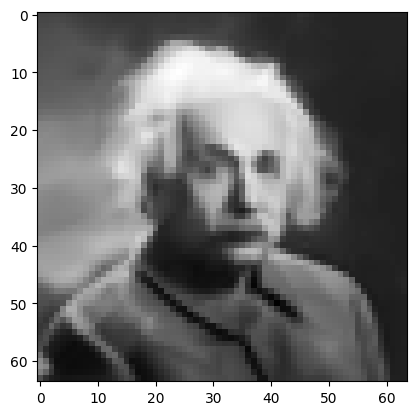

Training completed: 90%
Total loss: 0.028878 



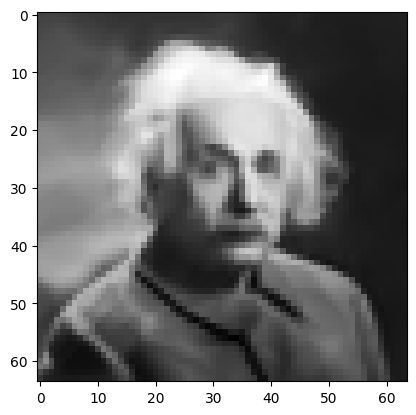

In [ ]:
model_ne = INR_FC()
model_ne.to(device)

train(model_ne)

# Question
Observe that you train for 1,000 epochs---much more than on previous assignments in class. **Why do you need to train for so many epochs?**

# Answer
The model seems to learn the high frequency features (the details) very slowly. This is the spectral bias you explored in question 1: it is easier to learn simple patterns that generalize than it is to learn overfitted complex patterns. One way to overcome this inductive bias is to train for many epochs to give the model time to learn the more complex patterns which have smaller gradients.

# Compare the visualizations
Now plot the model's reconstructed image in comparison to the actual image as well as the 2x super resolution.

In [ ]:
def visualize_comparisons(model, batch_size = 64, loss_fn = nn.MSELoss()):
  # see comparisons
  print("actual 1x:")
  visualize_data(img)
  print("neural net 1x:")
  dataloader = DataLoader(get_dataset(), batch_size=batch_size, shuffle=True)
  test_loop(dataloader, model, loss_fn)

  print("neural net 2x:")
  dataloader = DataLoader(get_dataset(img.shape[0]*2), batch_size=batch_size)
  test_loop(dataloader, model, loss_fn)
  print("actual 2x:")
  visualize_data(get_img(img.shape[0]*2))

actual 1x:


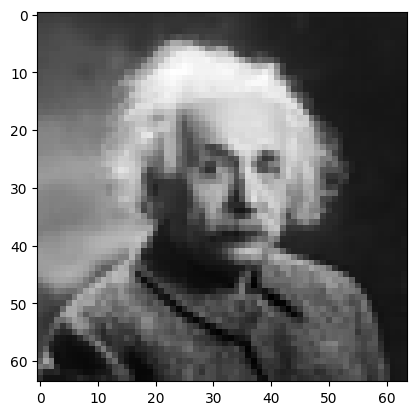

neural net 1x:
Total loss: 0.026903 



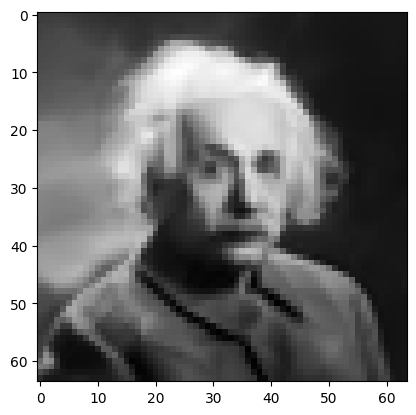

neural net 2x:
Total loss: 0.491143 



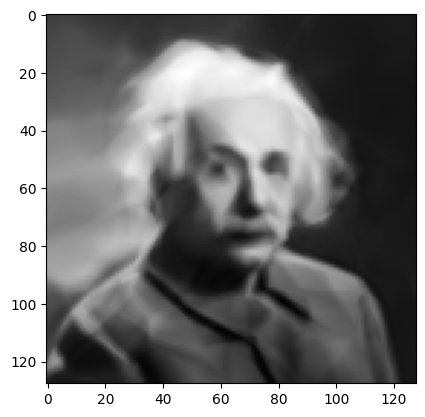

actual 2x:


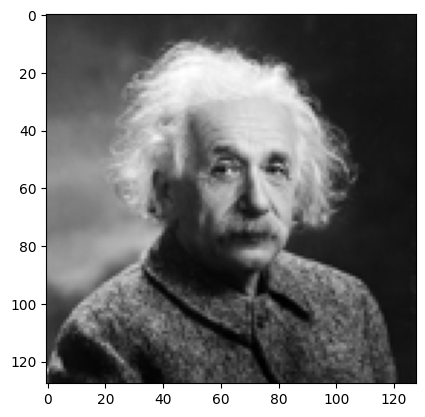

In [ ]:
visualize_comparisons(model_ne)

# Fourier Features Encoding
The no-encoding model struggles with spectral bias. You saw that one way to overcome that is through training for many epochs. You will now explore a different way to overcome spectral bias: fourier feature encodings. **Implement the fourier feature encodings as we have learned in lecture.**

*Hint: See section 5.1 of https://arxiv.org/abs/2003.08934*

In [ ]:
class FourierFeatureEncoding(nn.Module):
  # https://arxiv.org/abs/2003.08934 section 5.1
  
  def __init__(self, in_dim, num_frequencies=None, scale=2):
    super().__init__()

    self.scale = scale
    self.num_frequencies = num_frequencies if num_frequencies is not None else 10 if in_dim>= 3 else 4
    
    self.in_dim = in_dim
    self.out_dim = 2 * in_dim * self.num_frequencies

    self.register_buffer("frequencies", self.scale ** torch.arange(self.num_frequencies) * np.pi)

  def forward(self, coords):
    ############################################################################
    # TODO: implement
    t = einops.einsum(self.frequencies, coords, "f, bsz c -> bsz f c")
    t = einops.rearrange(t, 'bsz f c -> bsz (f c)')
    sin = torch.sin(t)
    cos = torch.cos(t)
    enc,_ = einops.pack([sin,cos],'bsz *')
    ############################################################################
    return enc

In [ ]:
#@title Ensure your code passes the following tests:
torch.manual_seed(100)

layer_test = FourierFeatureEncoding(1,3)
assert torch.allclose(
    layer_test(torch.tensor([[0.123]],dtype=torch.float)),
    torch.tensor([[0.3769, 0.6982, 0.9997, 0.9263, 0.7159, 0.0251]],dtype=torch.float),
    rtol=1e-2
)

layer_test = FourierFeatureEncoding(2,2)
assert torch.allclose(
    layer_test(torch.tensor([[0.321,0.567],[.1,.2]],dtype=torch.float)),
    torch.tensor(
        [[ 0.8460,  0.9779,  0.9021, -0.4086,  0.5332, -0.2089, -0.4315, -0.9127],
        [ 0.3090,  0.5878,  0.5878,  0.9511,  0.9511,  0.8090,  0.8090,  0.3090]],dtype=torch.float),
    rtol=1e-2
)

layer_test = FourierFeatureEncoding(10,1)
assert torch.allclose(
    layer_test(torch.tensor([[0,.1,.2,.3,.4,.5,.6,.7,.8,.9]],dtype=torch.float)),
    torch.tensor(
        [[ 0.0000e+00,  3.0902e-01,  5.8779e-01,  8.0902e-01,  9.5106e-01,
          1.0000e+00,  9.5106e-01,  8.0902e-01,  5.8779e-01,  3.0902e-01,
          1.0000e+00,  9.5106e-01,  8.0902e-01,  5.8779e-01,  3.0902e-01,
         -4.3711e-08, -3.0902e-01, -5.8779e-01, -8.0902e-01, -9.5106e-01]],dtype=torch.float),
    rtol=1e-2
)

  0%|          | 0/100 [00:00<?, ?it/s]

Training completed: 0%
Total loss: 1.108411 



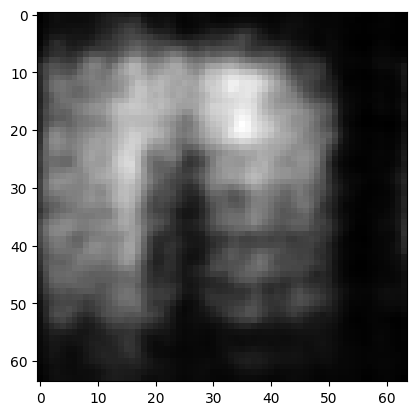

Training completed: 10%
Total loss: 0.077630 



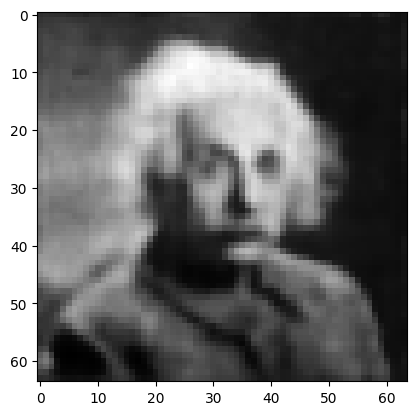

Training completed: 20%
Total loss: 0.035679 



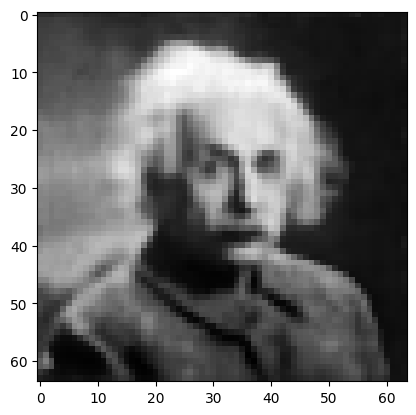

Training completed: 30%
Total loss: 0.027542 



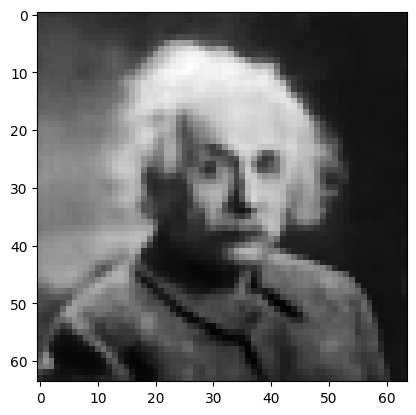

Training completed: 40%
Total loss: 0.025080 



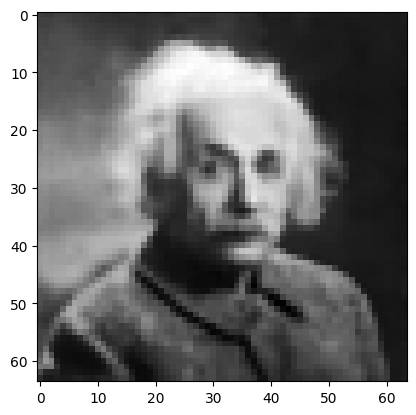

Training completed: 50%
Total loss: 0.016075 



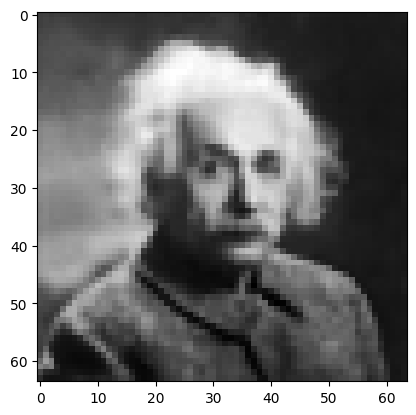

Training completed: 60%
Total loss: 0.020653 



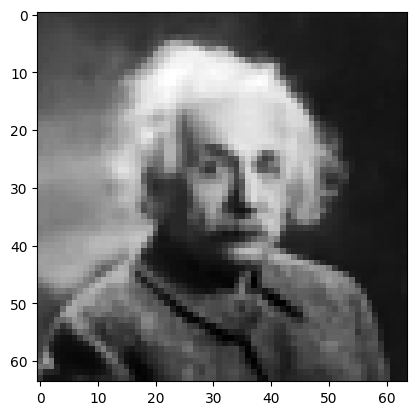

Training completed: 70%
Total loss: 0.016423 



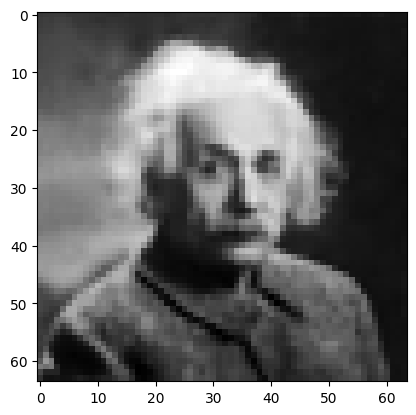

Training completed: 80%
Total loss: 0.017958 



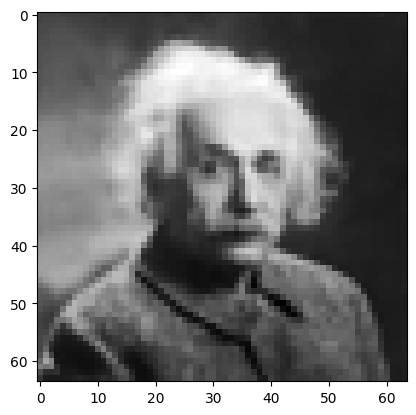

Training completed: 90%
Total loss: 0.016894 



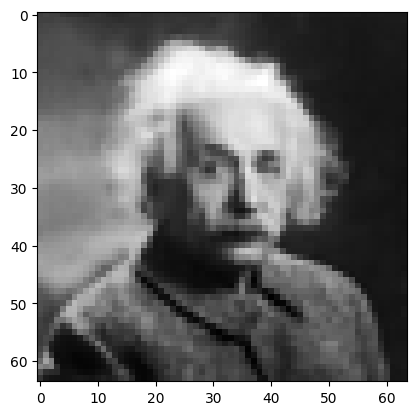

actual 1x:


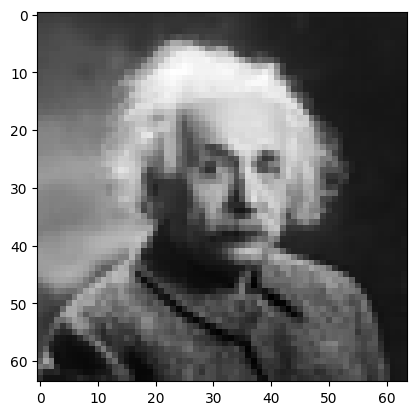

neural net 1x:
Total loss: 0.016814 



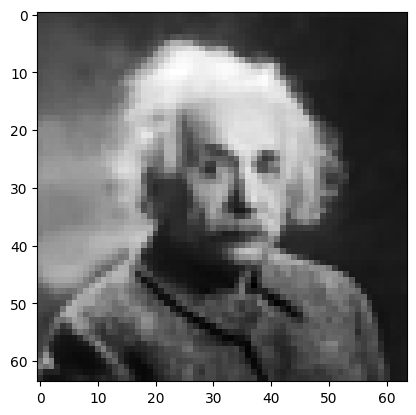

neural net 2x:
Total loss: 0.550590 



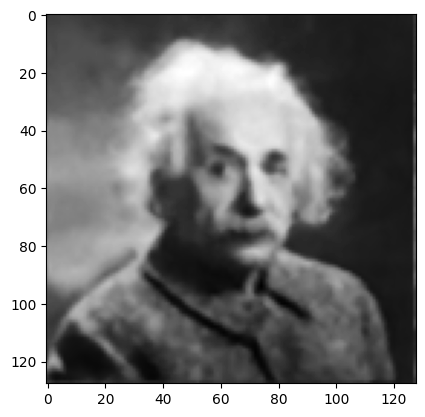

actual 2x:


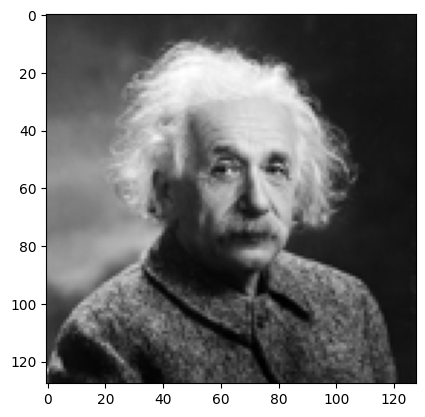

In [ ]:
#@title Train the fourier-feature encoding model

model_ffe = INR_FC(encoding_class=FourierFeatureEncoding)
model_ffe.to(device)

train(model_ffe,epochs=100) # 10x less epochs!
visualize_comparisons(model_ffe)

Wow, fourier features encoding performs much better than no-encoding! Let's try a bigger image with fourier encoding.

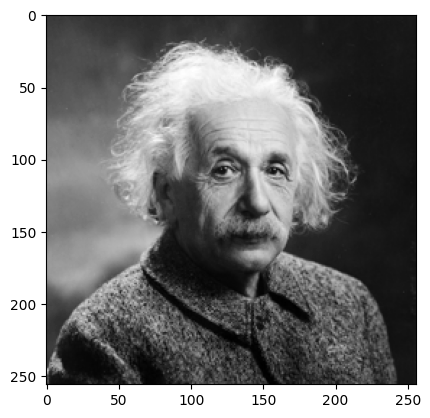

  0%|          | 0/100 [00:00<?, ?it/s]

Training completed: 0%
Total loss: 4.525773 



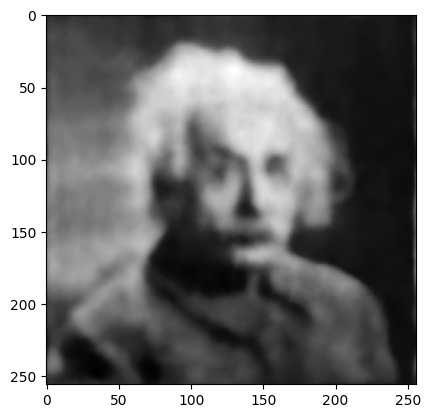

Training completed: 10%
Total loss: 2.524256 



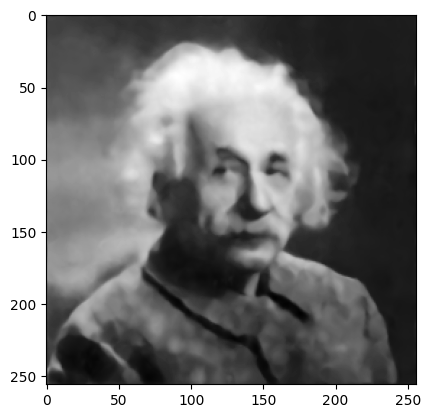

Training completed: 20%
Total loss: 2.014644 



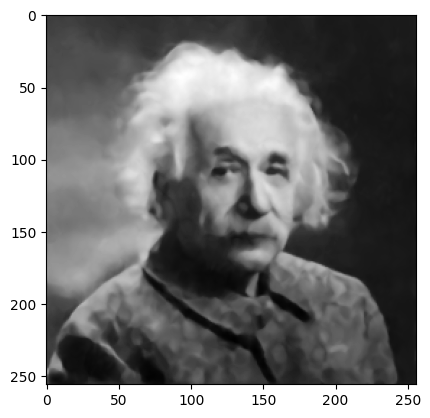

Training completed: 30%
Total loss: 1.769589 



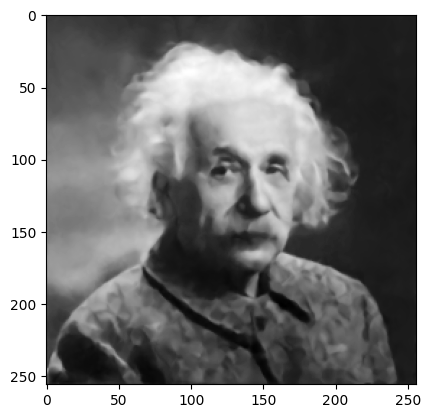

Training completed: 40%
Total loss: 1.665456 



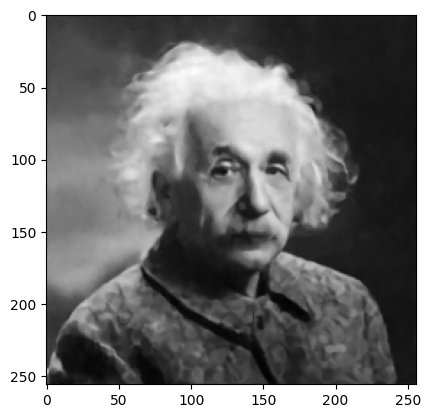

Training completed: 50%
Total loss: 1.465124 



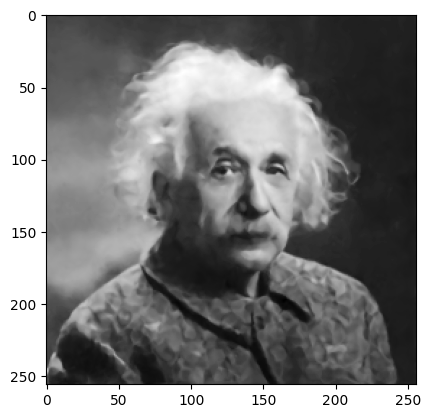

Training completed: 60%
Total loss: 1.368682 



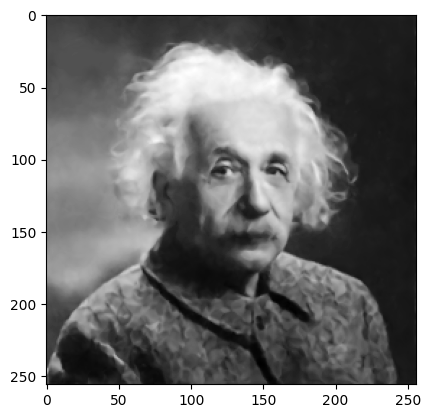

Training completed: 70%
Total loss: 1.249615 



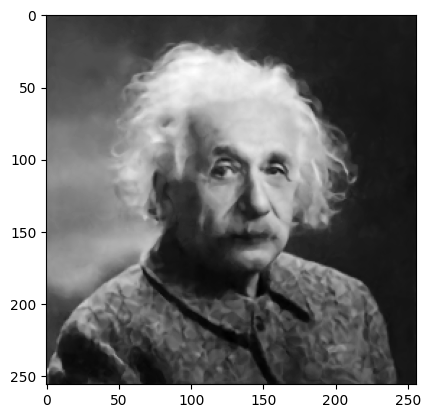

Training completed: 80%
Total loss: 1.224980 



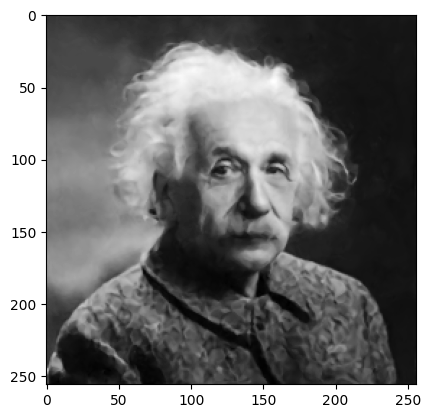

Training completed: 90%
Total loss: 1.156897 



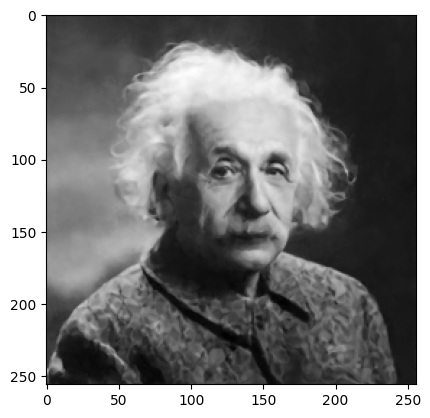

actual 1x:


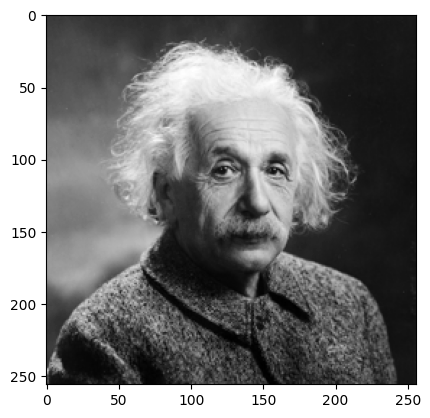

neural net 1x:
Total loss: 1.173934 



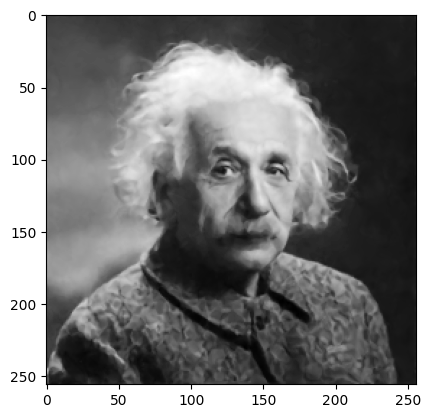

neural net 2x:
Total loss: 11.957473 



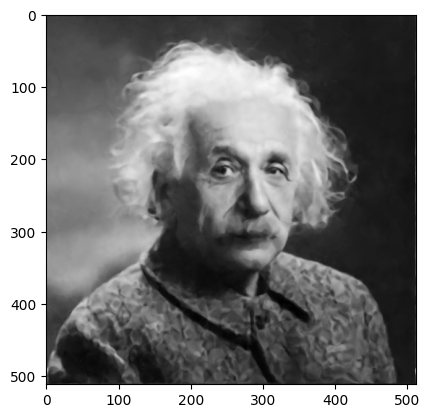

actual 2x:


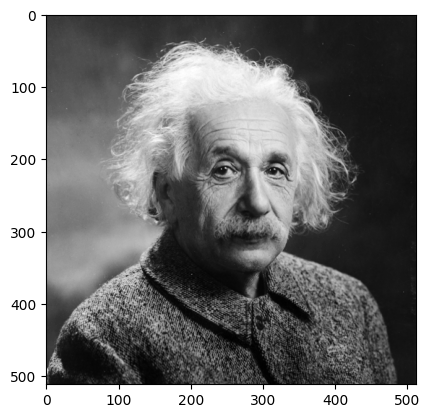

In [ ]:
img = get_img(256) # 4x bigger in each coordinate
visualize_data(img)

model_ffe = INR_FC(encoding_class=FourierFeatureEncoding)
model_ffe.to(device)

train(model_ffe,epochs=100) # still 10x less epochs than no-encoding
visualize_comparisons(model_ffe)

It looks pretty good, but the training time is starting to get long again. Can we do even better? Yes, see question 3 for a completely different encoding style!

[Optional]: For more fourier-like encodings, see also section 6.1 of https://arxiv.org/abs/2006.10739